# (08) Sim -- many seeds ```dim=65```

**Motivation**: Test whether generating few frames but across many different random seeds will result in similarity between frames. Find nearest neighbor of each frame using kNN and plot the distribution of min distances. It turns out using many seeds is just like generating all frames in one go. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from figures.fighelper import *
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _do_pca(a):
    a = flatten_arr(a, ndim_end=0, ndim_start=1)
    u, s, v = sp_lin.svd(a, full_matrices=False, compute_uv=True)
    s *= 100 / s.sum()
    titles = [f"{e:0.1f} %" for e in s]
    pcs = v.reshape(-1, of.dim, of.dim, 2)
    return s, pcs, titles


def _plot_singular_values(s, thres=90):
    fig, axes = create_figure(2, 1, (13, 7), sharex='all')
    axes[0].plot(s, marker='.')
    axes[1].plot(np.cumsum(s), lw=3, marker=None)

    idx = np.where(np.cumsum(s) > thres)[0][0]
    axes[1].axvline(
        idx, color='g', ls=':', lw=1.5,
        label=f'{idx} dimensions',
    )
    axes[1].axhline(
        thres, color='magenta', ls=':', lw=1.5,
        label=f'{thres}% of variance',
    )
    axes[1].legend()

    axes[1].axhline(0, color='k', ls='--', lw=1.2)
    axes[1].axhline(100, color='k', ls='--', lw=1.2)
    axes[1].set_ylim((-3, 103))
    add_grid(axes)
    plt.show()

    
def _sizes_hist(of, obj_i: int = 0):
    fig, ax = create_figure(1, 1, (15, 5))
    size_pix = of.objects[obj_i].size * of.dim ** 2
    sns.histplot(size_pix, bins=np.linspace(0, 80, 81) - 0.5, stat='percent', ax=ax)

    for color, thres in zip(['magenta', 'k', 'g', 'r'], [2, 4, 6, 8]):
        lbl = f'{100 * (size_pix < thres).sum() / of.n:0.1f}% smaller than {thres} pixels'
        ax.axvline(thres, color=color, ls='--', lw=1.3, label=lbl)
    ax.legend(fontsize=17)
    plt.show()

## Prepare

In [3]:
from skimage.transform import resize

kws = dict(
    dim=65,
    fov=45.0,
    obj_r=0.2,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 5.0),
    vlim_slf=(0.01, 5.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 6

{
    'dim': 65,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [4]:
kws = {
    'category': 'fixate',
    'n': int(1e4),
    'n_obj': 1,
    **kws,
}
print(kws)

{
    'category': 'fixate',
    'n': 10000,
    'n_obj': 1,
    'dim': 65,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [5]:
%%time

g_dict = {}
for seed in range(1):
    kws['seed'] = seed
    of = OpticFlow(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    _, g, *_ = of.groundtruth_factors()
    g_dict[seed] = g
    
g_all = np.concatenate(list(g_dict.values()), axis=-1)
g_all.shape

CPU times: user 1min 8s, sys: 6.73 s, total: 1min 15s
Wall time: 1min 15s


(11, 10000)

In [6]:
accept.sum()

9738

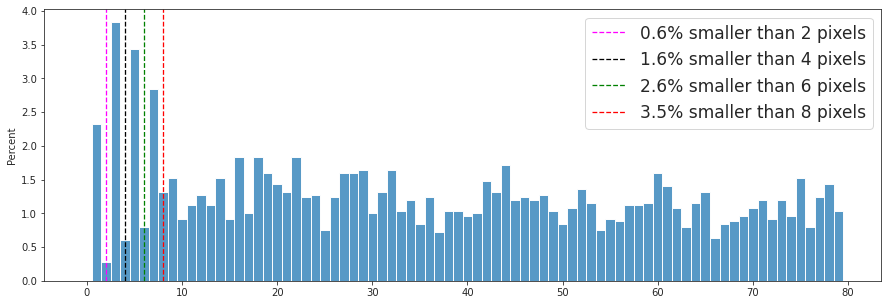

In [7]:
_sizes_hist(of)

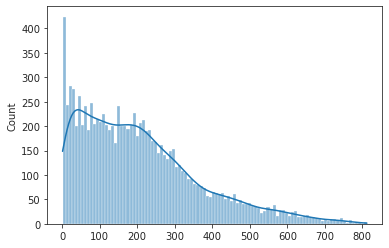

In [8]:
sns.histplot(of.objects[0].size * of.dim ** 2, bins=100, kde=True);

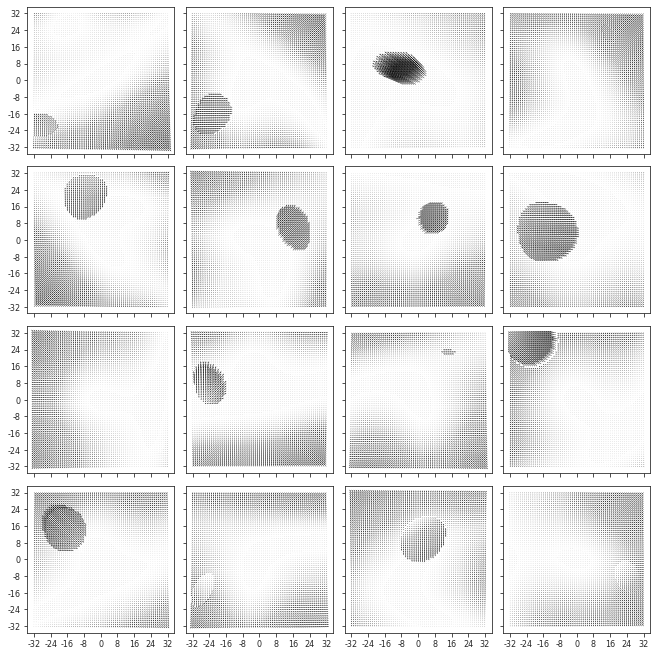

In [9]:
show_opticflow(of.alpha_dot, tick_spacing=8);

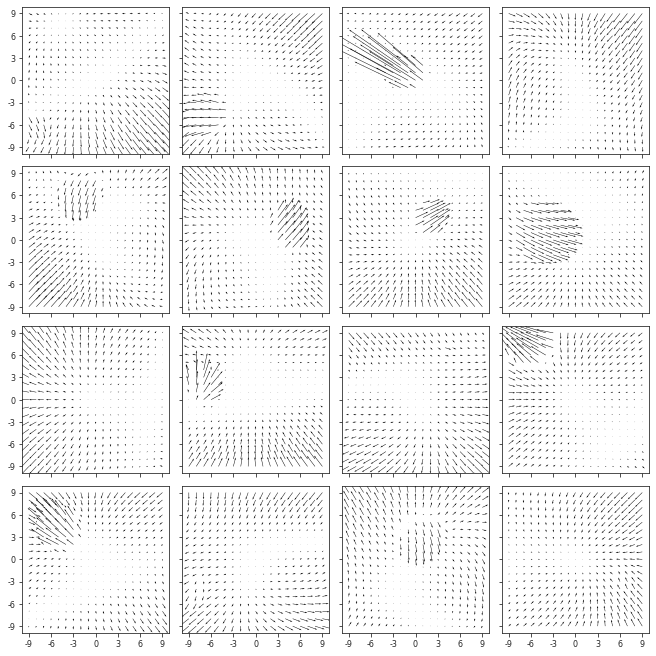

In [10]:
show_opticflow(resize(of.alpha_dot[:16], (16, 19, 19, 2)));

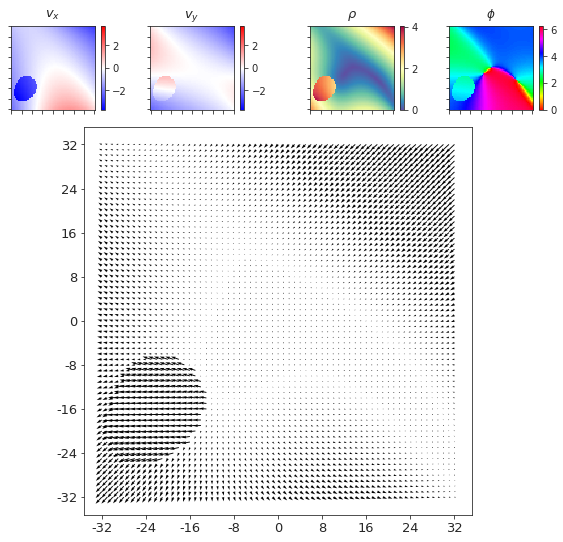

In [25]:
show_opticflow_full(of.alpha_dot[1], tick_spacing=8);

In [26]:
print(kws)

{
    'category': 'fixate',
    'n': 10000,
    'n_obj': 1,
    'dim': 65,
    'fov': 45.0,
    'obj_r': 0.2,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 5.0),
    'vlim_slf': (0.01, 5.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

In [27]:
%%time

g_all = []
g_aux_all = []
alpha_dot_all = []
for seed in tqdm(range(60)):
    kws['seed'] = seed
    of = OpticFlow(**kws).compute_coords()
    _ = of.compute_flow()
    accept = of.filter(min_obj_size)
    f, g, f_aux, g_aux = of.groundtruth_factors()
    alpha_dot_all.append(of.alpha_dot.astype('float32'))
    g_aux_all.append(g_aux)
    g_all.append(g)

alpha_dot_all = np.concatenate(alpha_dot_all, axis=0)
g_all, g_aux_all = cat_map([g_all, g_aux_all], axis=-1)

alpha_dot_all.shape, g_all.shape, g_aux_all.shape

100%|██████████| 60/60 [1:16:27<00:00, 76.46s/it]


CPU times: user 1h 9min 8s, sys: 7min 33s, total: 1h 16min 42s
Wall time: 1h 16min 46s


((600000, 65, 65, 2), (11, 600000), (21, 600000))

In [28]:
len(f), len(f_aux)

(11, 21)

In [29]:
sys.getsizeof(alpha_dot_all) / 1e9

20.280000152

In [30]:
sys.getsizeof(g_all) / 1e9, sys.getsizeof(g_aux_all) / 1e9

(0.05280012, 0.10080012)

## kNN

In [31]:
%%time

knn = sk_neigh.NearestNeighbors(n_neighbors=3, metric='euclidean').fit(g_all.T)
neigh_dist, neigh_ind = knn.kneighbors(g_all.T)
neigh_dist.shape, neigh_ind.shape

CPU times: user 6min 29s, sys: 149 ms, total: 6min 29s
Wall time: 6min 29s


((600000, 3), (600000, 3))

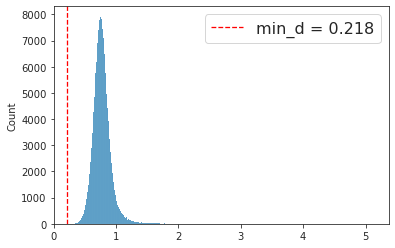

In [32]:
ax = sns.histplot(neigh_dist[:, 1])
min_d = min(neigh_dist[:, 1])
ax.axvline(min_d, color='r', ls='--', lw=1.3, label=f"min_d = {min_d:0.3f}")
ax.legend(fontsize=16)
ax.set_xlim(left=0);

In [33]:
closest_i = np.argmin(neigh_dist[:, 1])
closest_i

240871

In [34]:
neigh_dist[closest_i], neigh_ind[closest_i]

(array([0.        , 0.21802288, 0.71609541]), array([240871, 466737, 159306]))

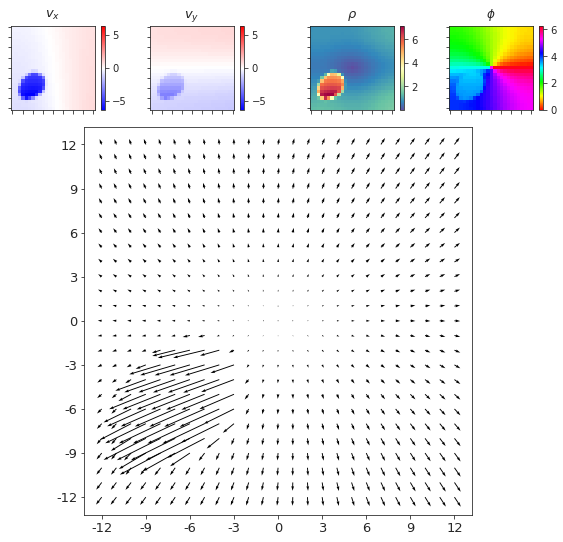

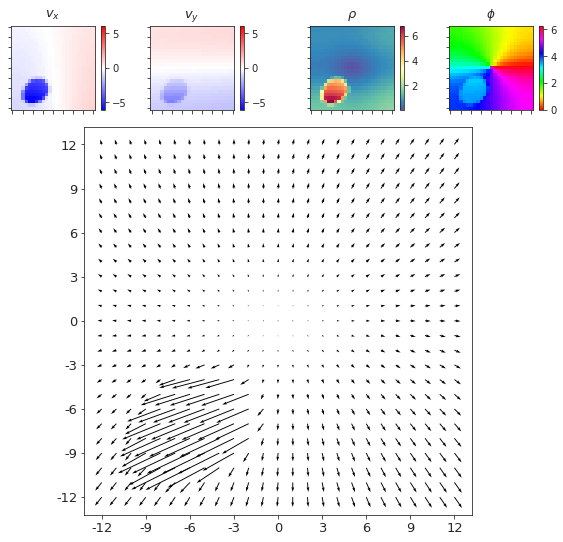

In [35]:
show_opticflow_full(resize(alpha_dot_all[neigh_ind[closest_i, 0]], (25, 25, 2)))
show_opticflow_full(resize(alpha_dot_all[neigh_ind[closest_i, 1]], (25, 25, 2)));